In [1]:
from __future__ import print_function
import sys
sys.path.append('../build/')
%pylab inline
np.set_printoptions(precision=4, suppress=True)
import versor as vsr
from versor.drawing import *
from motor_estimation import MotorEstimationSolver

Populating the interactive namespace from numpy and matplotlib


In [2]:
p1 = vsr.Vec(1,0,1).null()
p2 = vsr.Vec(2,0.2,1).null()

l1 = vsr.Dll(vsr.Vec(0,0,0).null(), vsr.Vec(1,0,0).null()).unit()

theta = pi/6
delta = 0.6


m = vsr.Vec(1,1,delta).trs() * vsr.Biv(theta/2,0,0).exp()

l1 = l1.spin(m)
l2 = l1.spin(m)
l3 = l2.comm(l1.rev())

l1_dir = l1.dir().vec().unit()
l1_loc = l1.loc(vsr.Vec(0,0,0).null()).vec()
l2_dir = l2.dir().vec().unit()
l2_loc = l2.loc(vsr.Vec(0,0,0).null()).vec()

l4 = vsr.Dll(l3.loc(vsr.Vec(0,0,0).null()), l3.biv().duale().unit())

p1 = l1.loc(l4.loc(vsr.Vec(0,0,0).null()))
p2 = l2.loc(l4.loc(vsr.Vec(0,0,0).null()))

p = ((p2.vec() + p1.vec()) * 0.5).null()

# bisector

lv = vsr.Dll(p, (l2_dir + l1_dir).unit())
lw = vsr.Dll(p, (l2_dir-l1_dir).unit())


l5 = l2 - l1

scene = Scene(children=[
        frame_mesh(),
        line_mesh(l1, color=Colors.DEEPSKYBLUE),
        point_mesh(p1,color=Colors.DEEPSKYBLUE),

        line_mesh(l2, color=Colors.DEEPPINK),
        point_mesh(p2,color=Colors.DEEPPINK),
        
        line_mesh(l3, color=Colors.BLACK),
        
        line_mesh(l5, color='lightgreen'),
        
        # midpoint
        point_mesh(p, color='lightgreen'),

        
#         bivector_mesh(l3.biv(), color='red'),
#         vector_mesh(B1.comm(bn.comm(B2) * delta), color='red'),
        
        line_mesh(lv, color='lightgreen'),

        
        AmbientLight(color='#777777')])

camera = PerspectiveCamera(position=[0, 5, 5], up=[0, 0, 1],
                      children=[DirectionalLight(color='white', 
                                                 position=[3, 5, 1], 
                                                 intensity=0.5)])
# camera.children = []

renderer = Renderer(camera=camera, 
                    scene=scene, 
                    controls=[TrackballControls(controlling=camera)],
                    background = 'white')
# renderer.width = '950'
# renderer.height = '713'
display(renderer)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


# Ground truth motor

In [3]:
delta = 0.6
theta = pi/6
motor = (vsr.Vec(1,2,3).unit() * delta ).trs() * vsr.Rot(vsr.Biv(1,2,3).unit() * theta)
print(motor)

Mot: [ 0.87 -0.13 -0.27 -0.4 -0.16 -0.22 -0.12 0.021 ]


# Dataset

In [45]:
n_points = 10
sigma = 0.09
points_a = [(vsr.Vec(0,0,0).null(),
             vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null()  )
            for i in range(n_points)]

points_a_noisy = [(vsr.Vec(*(np.array(a)[:3] + sigma * np.random.randn(3))).null(),
                   vsr.Vec(*(np.array(b)[:3] + sigma * np.random.randn(3))).null()) 
                  for a,b in points_a]

lines_a = [vsr.Dll(a,b).unit() for (a,b) in points_a]
lines_b = [line.spin(motor) for line in lines_a]

# Estimate motor

## Commutator

In [46]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b):
#     mes.add_line_correspondences_residual_block(a,b)
    mes.add_line_commutator_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_lines_6_res, summary_lines_6_res, _) = mes.solve()
print(summary_lines_6_res['full_report'])
print(em_lines_6_res)


Solver Summary (v 1.12.0-eigen-(3.3.1)-lapack-suitesparse-(4.5.3)-cxsparse-(3.1.9)-no_openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            10                       10
Residual                                   60                       60

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1
Linear solver ordering              AUTOMATIC        

## Difference

In [47]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b):
    mes.add_line_correspondences_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(em_lines_6_res, summary_lines_6_res, _) = mes.solve()
print(summary_lines_6_res['full_report'])
print(em_lines_6_res)


Solver Summary (v 1.12.0-eigen-(3.3.1)-lapack-suitesparse-(4.5.3)-cxsparse-(3.1.9)-no_openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            10                       10
Residual                                   60                       60

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1
Linear solver ordering              AUTOMATIC        

# Gauss-Newton

## Commutator

In [48]:
Jci = lambda ei, M, l1, l2 : np.array((ei.comm(l1.spin(M))).comm(l2)) * 2

In [49]:
fci = lambda M, l1, l2 : np.array(l1.spin(M).comm(l2)).reshape(6,1)

In [51]:
M = initial_motor
eps1 = 1e-6
eps2 = 1e-6
rsc = []
for i in range(10):
    k = len(rsc)
    Jc = np.array([np.array([Jci(ei, M, a, b) for ei in [vsr.Dll(1,0,0,0,0,0), 
                                                         vsr.Dll(0,1,0,0,0,0),
                                                         vsr.Dll(0,0,1,0,0,0),
                                                         vsr.Dll(0,0,0,1,0,0),
                                                         vsr.Dll(0,0,0,0,1,0),
                                                         vsr.Dll(0,0,0,0,0,1)]]).reshape(6,6).T 
                for a, b in zip(lines_a, lines_b)]).reshape(-1,6)
    print(Jc)
    fc = np.array([fci(M,a,b) for a, b in zip(lines_a, lines_b)]).reshape(-1,1)
    A = np.dot(Jc.T,Jc)
    g = np.dot(Jc.T, fc)
    r = np.dot(fc.T,fc)[0][0] / 2
    rsc.append(r)
    if r < 1e-6:
        break
    h = np.dot(np.linalg.pinv(A), -g)
    B = vsr.Dll(*h)
    M = B.exp() * M
print('r: ', r)
print(k)    
print(M)

[[-0.2415  0.6384 -1.2999  0.      0.      0.    ]
 [-0.4147 -1.3964  0.6421  0.      0.      0.    ]
 [-0.3596 -0.2734 -0.5243  0.      0.      0.    ]
 [-0.1347 -0.3255  0.0609 -0.5243  0.2734 -0.3596]
 [ 0.1554  0.0677  0.2847 -0.6421 -1.3964  0.4147]
 [ 0.6223  0.76    0.5764 -1.2999 -0.6384 -0.2415]
 [-0.8374  1.4175  0.373   0.      0.      0.    ]
 [ 0.338  -0.941   0.169   0.      0.      0.    ]
 [ 0.3901  0.7413 -1.3883  0.      0.      0.    ]
 [-0.1814 -0.0313  0.374  -1.3883 -0.7413  0.3901]
 [ 0.1572  0.1348 -0.4174 -0.169  -0.941  -0.338 ]
 [-0.4546 -0.0598  0.9212  0.373  -1.4175 -0.8374]
 [-1.3189  0.1032  0.0501  0.      0.      0.    ]
 [-1.2562  0.1578  0.6718  0.      0.      0.    ]
 [ 0.1198 -0.1319 -1.2893  0.      0.      0.    ]
 [ 0.0417  0.05    0.5573 -1.2893  0.1319  0.1198]
 [ 0.4372 -0.0577 -0.2624 -0.6718  0.1578  1.2562]
 [ 0.5497 -0.0392  0.0196  0.0501 -0.1032 -1.3189]
 [-1.865   0.245   0.3974  0.      0.      0.    ]
 [ 0.2851 -1.4766  0.8469  0.  

In [10]:
Jci = lambda ei, M, l1, l2 : np.array(((ei.comm(l1.spin(M))).comm(l2)).mot().dll()) * 2
fci = lambda M, l1, l2 : np.array((l1.spin(M).comm(l2)).mot().dll()).reshape(6,1)
M = initial_motor
eps1 = 1e-6
eps2 = 1e-6
rsc = []
for i in range(10):
    k = len(rsc)
    Jc = np.array([np.array([Jci(vsr.CGA(ei), 
                                 vsr.CGA(M), 
                                 vsr.CGA(a.undual()),
                                 vsr.CGA(b.undual())) for ei in [vsr.Dll(1,0,0,0,0,0), 
                                                      vsr.Dll(0,1,0,0,0,0),
                                                      vsr.Dll(0,0,1,0,0,0),
                                                      vsr.Dll(0,0,0,1,0,0),
                                                      vsr.Dll(0,0,0,0,1,0),
                                                      vsr.Dll(0,0,0,0,0,1)]]).reshape(6,6).T 
                for a, b in zip(lines_a, lines_b)]).reshape(-1,6)
    fc = np.array([fci(vsr.CGA(M),
                       vsr.CGA(a.undual()),
                       vsr.CGA(b.undual())) for a, b in zip(lines_a, lines_b)]).reshape(-1,1)

    A = np.dot(Jc.T,Jc)
    g = np.dot(Jc.T,fc)
    r = np.dot(fc.T,fc)[0][0] / 2
    rsc.append(r)
    if r < 1e-6:
        break
    h = np.dot(np.linalg.pinv(A), -g)
    B = vsr.Dll(*h)
    M = B.exp() * M
print('r: ', r)
print(k)    
print(M)

r:  7.74902653587e-13
3
Mot: [ 0.87 -0.13 -0.27 -0.4 -0.16 -0.22 -0.12 0.021 ]


## Difference

In [11]:
Jdi = lambda ei, M, l1, l2 : np.array((ei.comm(l1.spin(M)))) * 2

In [12]:
fdi = lambda M, l1, l2 : np.array(l1.spin(M) - l2).reshape(6,1)

In [13]:
M = initial_motor
rsd = []
for i in range(10):
    k = len(rsd)
    Jd = np.array([np.array([Jdi(ei, M, a, b) for ei in [vsr.Dll(1,0,0,0,0,0), 
                                                      vsr.Dll(0,1,0,0,0,0),
                                                      vsr.Dll(0,0,1,0,0,0),
                                                      vsr.Dll(0,0,0,1,0,0),
                                                      vsr.Dll(0,0,0,0,1,0),
                                                      vsr.Dll(0,0,0,0,0,1)]]).reshape(6,6).T 
                for a, b in zip(lines_a, lines_b)]).reshape(-1,6)
    fd = np.array([fdi(M,a,b) for a, b in zip(lines_a, lines_b)]).reshape(-1,1)
    A = np.dot(Jd.T,Jd)
    g = np.dot(Jd.T, fd)
    r = np.dot(fd.T,fd)[0][0] / 2
    rsd.append(r)
    if r < 1e-6:
        print('r: ', r)
        break
    h = np.dot(np.linalg.pinv(A), -g)
    B = vsr.Dll(*h)
    M = B.exp() * M
print(k)
print(M)

r:  6.24767391636e-11
3
Mot: [ 0.87 -0.13 -0.27 -0.4 -0.16 -0.22 -0.12 0.021 ]


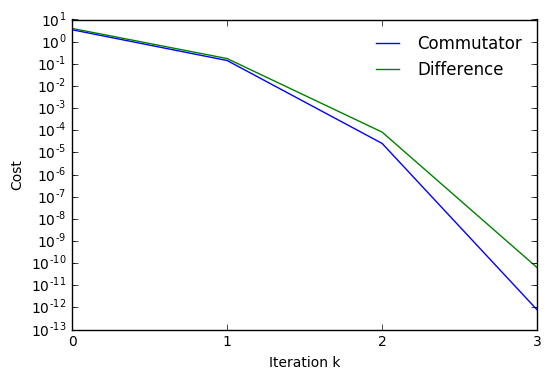

In [14]:
fig, ax = plt.subplots(1)
ax.plot(rsc, label=r'Commutator')
ax.plot(rsd, label=r'Difference')
ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Iteration k')
plt.ylabel(r'Cost')
# plt.savefig('lines-cost-engage.eps')

## Planes

In [15]:
n_planes = 10
planes_a = []
for i in range(10):
    dir_vec = np.random.normal(0.0, 0.8, 4)
    dir_vec = dir_vec / np.linalg.norm(dir_vec)
    distance = np.random.normal(0.0, 0.8,1)
    arr = dir_vec + distance
    planes_a.append(vsr.Dlp(dir_vec[0],dir_vec[1],dir_vec[2],distance[0]))
planes_b = [plane.spin(motor) for plane in planes_a]

In [53]:
Jci = lambda ei, M, l1, l2 : np.array(((ei.comm(l1.spin(M))).comm(l2)).mot().dll()) * 2
fci = lambda M, l1, l2 : np.array((l1.spin(M).comm(l2)).mot().dll()).reshape(6,1)

In [54]:
M = initial_motor
eps1 = 1e-6
eps2 = 1e-6
rsc = []
for i in range(10):
    k = len(rsc)
    Jc = np.array([np.array([Jci(vsr.CGA(ei), 
                                 vsr.CGA(M), 
                                 vsr.CGA(a),
                                 vsr.CGA(b)) for ei in [vsr.Dll(1,0,0,0,0,0), 
                                                      vsr.Dll(0,1,0,0,0,0),
                                                      vsr.Dll(0,0,1,0,0,0),
                                                      vsr.Dll(0,0,0,1,0,0),
                                                      vsr.Dll(0,0,0,0,1,0),
                                                      vsr.Dll(0,0,0,0,0,1)]]).reshape(6,6).T 
                for a, b in zip(planes_a, planes_b)]).reshape(-1,6)
    fc = np.array([fci(vsr.CGA(M),
                       vsr.CGA(a),
                       vsr.CGA(b)) for a, b in zip(planes_a, planes_b)]).reshape(-1,1)

    print(Jc)
    A = np.dot(Jc.T,Jc)
    g = np.dot(Jc.T,fc)
    r = np.dot(fc.T,fc)[0][0] / 2
    rsc.append(r)
    if r < 1e-6:
        break
    h = np.dot(np.linalg.pinv(A), -g)
    B = vsr.Dll(*h)
    M = B.exp() * M
print('r: ', r)
print(k)    
print(M)

[[ 0.178   0.0368  0.0289  0.      0.      0.    ]
 [ 0.3183  0.0365 -0.1568  0.      0.      0.    ]
 [-0.045   0.0283  0.2588  0.      0.      0.    ]
 [-1.4015 -0.258   0.     -0.0222 -0.1568 -0.0289]
 [ 0.198   0.     -0.258   0.0283  0.2001  0.0368]
 [ 0.      0.198   1.4015  0.045   0.3183  0.0586]
 [ 1.4553  0.0637  0.2804  0.      0.      0.    ]
 [ 0.0022  1.2498 -0.908   0.      0.      0.    ]
 [ 0.003  -0.2836  0.2069  0.      0.      0.    ]
 [-0.4951 -0.1529  0.      1.2491 -0.908  -0.2804]
 [-0.6811  0.     -0.1529 -0.2836  0.2062  0.0637]
 [ 0.     -0.6811  0.4951 -0.003   0.0022  0.0007]
 [ 0.6868 -0.4229  1.1042  0.      0.      0.    ]
 [ 0.1613  1.226  -0.5293  0.      0.      0.    ]
 [ 0.271   0.3406  0.1338  0.      0.      0.    ]
 [-0.629  -1.3121  0.      0.8895 -0.5293 -1.1042]
 [-1.0569  0.     -1.3121  0.3406 -0.2027 -0.4229]
 [ 0.     -1.0569  0.629  -0.271   0.1613  0.3365]
 [-0.0957 -0.5755  0.6923  0.      0.      0.    ]
 [ 0.2564  0.8254 -0.2484  0.  

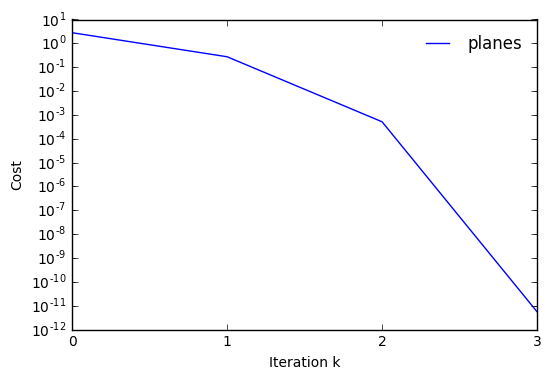

In [18]:
fig, ax = plt.subplots(1)
ax.plot(rsc, label=r'planes')
ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Iteration k')
plt.ylabel(r'Cost')
# plt.savefig('lines-cost-engage.eps')

## Points

In [55]:
ni = vsr.CGA(*[0]*32); ni[5] = 1; print(ni)

CGA: [ 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ]


In [56]:
n_points=10
points_a = [vsr.CGA(vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null()) ^ ni for i in range(n_points)]
points_b = [point.spin(vsr.CGA(motor)) for point in points_a]

In [62]:
M = initial_motor
eps1 = 1e-6
eps2 = 1e-6
rsc = []
for i in range(10):
    k = len(rsc)
    Jc = np.array([np.array([Jci(vsr.CGA(ei), 
                                 vsr.CGA(M), 
                                 (a),
                                 (b)) for ei in [vsr.Dll(1,0,0,0,0,0), 
                                                      vsr.Dll(0,1,0,0,0,0),
                                                      vsr.Dll(0,0,1,0,0,0),
                                                      vsr.Dll(0,0,0,1,0,0),
                                                      vsr.Dll(0,0,0,0,1,0),
                                                      vsr.Dll(0,0,0,0,0,1)]]).reshape(6,6).T 
                for a, b in zip(points_a, points_b)]).reshape(-1,6)
    fc = np.array([fci(vsr.CGA(M),
                       (a),
                       (b)) for a, b in zip(points_a, points_b)]).reshape(-1,1)

#     print(Jc)
    A = np.dot(Jc.T,Jc)
#     print(A)
    g = np.dot(Jc.T,fc)
    r = np.dot(fc.T,fc)[0][0] / 2
    rsc.append(r)
    if r < 1e-6:
        break
#     h = np.dot(np.linalg.pinv(A), -g)
    h = np.linalg.solve(A,-g)
    B = vsr.Dll(*h)
    M = B.exp() * M
print('r: ', r)
print(k)    
print(M)

r:  1.98857563467e-09
3
Mot: [ 0.87 -0.13 -0.27 -0.4 -0.16 -0.22 -0.12 0.021 ]


In [22]:
print(Jc[:6,:])

[[ 0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.    ]
 [-2.5145 -3.5249  0.      2.      0.      0.    ]
 [-0.1027  0.     -3.5249  0.      2.      0.    ]
 [ 0.     -0.1027  2.5145  0.      0.      2.    ]]


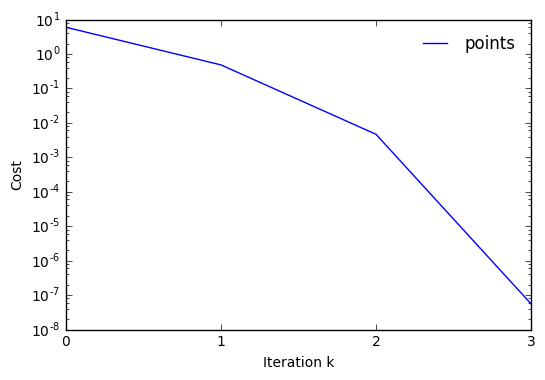

In [23]:
fig, ax = plt.subplots(1)
ax.plot(rsc, label=r'points')
ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel(r'Iteration k')
plt.ylabel(r'Cost')
# plt.savefig('lines-cost-engage.eps')

# Points, Lines, and Planes

In [24]:
Jci = lambda ei, M, l1, l2 : np.array(((ei.comm(l1.spin(M))).comm(l2)).mot().dll()) * 2
fci = lambda M, l1, l2 : np.array((l1.spin(M).comm(l2)).mot().dll()).reshape(6,1)
M = initial_motor
eps1 = 1e-6
eps2 = 1e-6
rsc = []
for i in range(10):
    k = len(rsc)
    Jlin = np.array([np.array([Jci(vsr.CGA(ei), 
                                 vsr.CGA(M), 
                                 vsr.CGA(a.undual()),
                                 vsr.CGA(b.undual())) for ei in [vsr.Dll(1,0,0,0,0,0), 
                                                      vsr.Dll(0,1,0,0,0,0),
                                                      vsr.Dll(0,0,1,0,0,0),
                                                      vsr.Dll(0,0,0,1,0,0),
                                                      vsr.Dll(0,0,0,0,1,0),
                                                      vsr.Dll(0,0,0,0,0,1)]]).reshape(6,6).T 
                for a, b in zip(lines_a, lines_b)]).reshape(-1,6)
    flin = np.array([fci(vsr.CGA(M),
                       vsr.CGA(a.undual()),
                       vsr.CGA(b.undual())) for a, b in zip(lines_a, lines_b)]).reshape(-1,1)
    Jpln = np.array([np.array([Jci(vsr.CGA(ei), 
                                 vsr.CGA(M), 
                                 vsr.CGA(a.undual()),
                                 vsr.CGA(b.undual())) for ei in [vsr.Dll(1,0,0,0,0,0), 
                                                      vsr.Dll(0,1,0,0,0,0),
                                                      vsr.Dll(0,0,1,0,0,0),
                                                      vsr.Dll(0,0,0,1,0,0),
                                                      vsr.Dll(0,0,0,0,1,0),
                                                      vsr.Dll(0,0,0,0,0,1)]]).reshape(6,6).T 
                for a, b in zip(planes_a, planes_b)]).reshape(-1,6)
    fpln = np.array([fci(vsr.CGA(M),
                       vsr.CGA(a.undual()),
                       vsr.CGA(b.undual())) for a, b in zip(planes_a, planes_b)]).reshape(-1,1)
    
    Jpnt = np.array([np.array([Jci(vsr.CGA(ei), 
                                 vsr.CGA(M), 
                                 (a),
                                 (b)) for ei in [vsr.Dll(1,0,0,0,0,0), 
                                                      vsr.Dll(0,1,0,0,0,0),
                                                      vsr.Dll(0,0,1,0,0,0),
                                                      vsr.Dll(0,0,0,1,0,0),
                                                      vsr.Dll(0,0,0,0,1,0),
                                                      vsr.Dll(0,0,0,0,0,1)]]).reshape(6,6).T 
                for a, b in zip(points_a, points_b)]).reshape(-1,6)
    fpnt = np.array([fci(vsr.CGA(M),
                       (a),
                       (b)) for a, b in zip(points_a, points_b)]).reshape(-1,1)
    
    Jc = np.vstack((Jlin, Jpln, Jpnt))
    fc = np.vstack((flin, fpln, fpnt))

    A = np.dot(Jc.T,Jc)
    print(A)
    g = np.dot(Jc.T,fc)
    r = np.dot(fc.T,fc)[0][0] / 2
    rsc.append(r)
    if r < 1e-6:
        break
    h = np.dot(np.linalg.pinv(A), -g)
    B = vsr.Dll(*h)
    M = B.exp() * M
print('r: ', r)
print(k)    
print(M)

[[ 83.1102   2.1504 -12.8544   1.6969  -7.7236  -0.433 ]
 [  2.1504  69.8554 -10.4641   0.5623  -1.147   -6.6401]
 [-12.8544 -10.4641  79.6749  -1.8018  -4.3316  -5.0988]
 [  1.6969   0.5623  -1.8018  63.1038   7.3897  -3.0896]
 [ -7.7236  -1.147   -4.3316   7.3897  72.7195   7.012 ]
 [ -0.433   -6.6401  -5.0988  -3.0896   7.012   70.7513]]
[[  82.3455    7.0106    2.0836  -12.1388   -0.4955    0.6748]
 [   7.0106   96.214   -10.1113  -25.2003   -2.0077    2.2592]
 [   2.0836  -10.1113  103.971    -2.7979  -23.345    11.7344]
 [ -12.1388  -25.2003   -2.7979   73.7837    4.5646   -3.2377]
 [  -0.4955   -2.0077  -23.345     4.5646   69.366     4.0478]
 [   0.6748    2.2592   11.7344   -3.2377    4.0478   79.2524]]
[[  86.0986    6.3095    2.6217  -17.0407    3.8649    1.2687]
 [   6.3095   93.7463   -8.2353  -21.1019   -1.1179    7.4008]
 [   2.6217   -8.2353  103.7065   -2.3866  -18.3286   17.756 ]
 [ -17.0407  -21.1019   -2.3866   74.6873    4.4139   -3.1939]
 [   3.8649   -1.1179  -18

In [25]:
planes_a[0].undual()

Pln: [ 1.789 -0.08201 0.4455 -0.06293 ]

In [26]:
## Spheres

In [39]:
sph1 = vsr.Sph(vsr.Vec(1,-1,1).null(), 0.3)
sph2 = vsr.Sph(vsr.Vec(2,-3,5).null(), 0.7)

In [44]:
(vsr.CGA(sph1) ^ ni )* (vsr.CGA(sph2) ^ ni).inv()

CGA: [ 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ]

In [34]:
vsr.CGA(sph.dual()) ^ ni

CGA: [ 0 0 0 0 0 0 0 0 0 0 0 0 1 -1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ]

In [32]:
sph.dual()

Dls: [ 1 -1 1 1 1.455 ]